In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au
import vis_utils as vu

In [3]:
sentinel, sentinel_eq, features, hypotheses = du.load_all_data(zscore_features=False, 
                                        zscore_hypotheses=False, equalize_sentinel=True,
                                        complete_only=True, n_max_patches=100,
                                        path_folder='/Users/tplas/data/2025-10 neureo/pecl-100-subsample-30km_v2',
                                        prefix_name='pecl176-')

n_patches = len(features)
n_hyp = hypotheses[0].shape[0]
n_feat = features[0].shape[0]
print(f"Number of patches: {n_patches}, number of hypotheses: {n_hyp}, number of features: {n_feat}")

 34%|███▍      | 171/500 [00:02<00:04, 72.29it/s]


Loaded 100 patches from /Users/tplas/data/2025-10 neureo/pecl-100-subsample-30km_v2, no NaNs or Infs found.
Number of patches: 100, number of hypotheses: 10, number of features: 64


In [4]:
(feat_hat_ols_cc_img, feat_res_ols_cc_img), (feat_hat_ols_h_img, feat_res_ols_h_img), (feat_orig, hyp_orig), (cca_corrs, r2_per_feature_cc, r2_per_feature_h) = au.cca_and_normal_ols_from_hypotheses(features=features, hypotheses=hypotheses)

Feature ravel shape: (1638400, 64), Hypothesis ravel shape: (1638400, 10)
Canonical correlations: [0.979 0.93  0.921 0.888 0.828 0.781 0.71  0.656 0.548 0.231]
CCA components shape: F (1638400, 10), H (1638400, 10)


In [11]:
np.mean(r2_per_feature_cc), np.mean(r2_per_feature_h)

(np.float64(0.6044946658864061), np.float64(0.46094156061200275))

In [16]:


import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # // Source - https://stackoverflow.com/a/57239611
    # // Posted by Naomi Fridman
    # // Retrieved 2025-11-20, License - CC BY-SA 4.0
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    r2_per_feature = 1 - np.sum((y_true - y_pred)**2, axis=0) / np.sum((y_true - np.mean(y_true, axis=0))**2, axis=0)
    assert len(r2_per_feature) == 64
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('mean r2 per feature: ', round(np.mean(r2_per_feature),4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

regression_results(y_true=au.ravel_features(np.stack(features, axis=0)).T, 
                   y_pred=au.ravel_features(np.stack(feat_hat_ols_cc_img, axis=0)).T)


explained_variance:  0.6045
mean_squared_log_error:  0.0023
r2:  0.6045
mean r2 per feature:  0.6045
MAE:  0.0359
MSE:  0.0022
RMSE:  0.0468


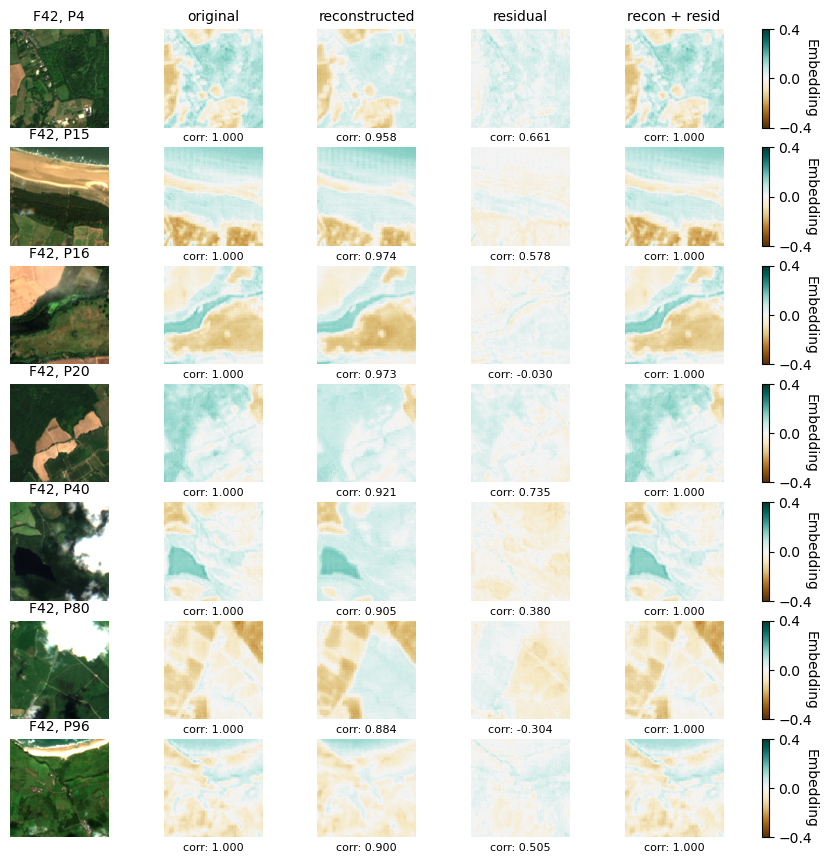

In [181]:
vu.plot_overview_cca_reconstruction(features, feat_hat_ols_cc_img, feat_res_ols_cc_img, sentinel,
                                    i_f=42)

In [18]:
dict_dim_all, dict_expl_var_all = {}, {}

for name, feat_tmp in zip(['original', 'fit_ols_cc', 'res_ols_cc', 'fit_ols_h', 'res_ols_h'], 
                      [np.stack(features), feat_hat_ols_cc_img, feat_res_ols_cc_img, feat_hat_ols_h_img, feat_res_ols_h_img]):
    print(name)
    dict_dim_all[name], dict_expl_var_all[name] = au.calculate_pca_dim(features_pca=feat_tmp)


original


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


fit_ols_cc


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


res_ols_cc


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


fit_ols_h


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


res_ols_h


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


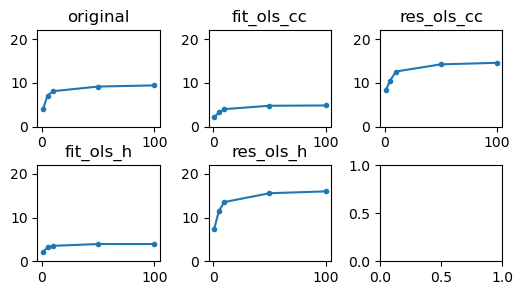

In [183]:
fig, ax = plt.subplots(2, 3, figsize=(6, 3), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
ax = ax.ravel()
for i_plot, (name, dict_dim) in enumerate(dict_dim_all.items()):
    n_vals = list(dict_dim.keys())
    mean_dim = [np.nanmean(dict_dim[n]) for n in n_vals]
    ax[i_plot].plot(n_vals, mean_dim, '.-', label=name)
    ax[i_plot].set_title(name)
    ax[i_plot].set_ylim(0, 22)

<BarContainer object of 5 artists>

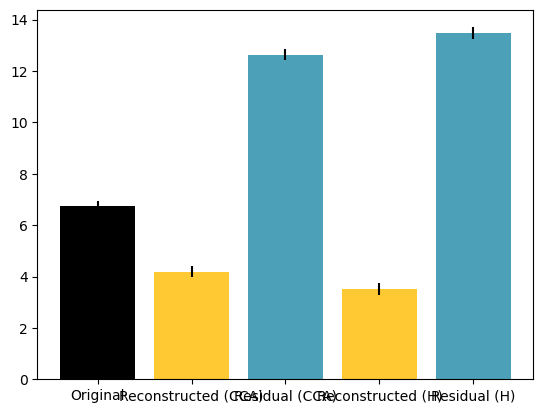

In [8]:
n = 10
ax = plt.subplot(111)
name_dict = {'original': 'Original', 'fit_ols_cc': 'Reconstructed (CCA)', 'res_ols_cc': 'Residual (CCA)',
              'fit_ols_h': 'Reconstructed (H)', 'res_ols_h': 'Residual (H)'}
color_dict = {'original': 'k', 'fit_ols_cc': "#FFC933", 'res_ols_cc': "#4CA1B8",
              'fit_ols_h': '#FFC933', 'res_ols_h': '#4CA1B8'}


mean_dim_list = []
name_list = []
colour_list = []
for name in ['original', 'fit_ols_cc', 'res_ols_cc', 'fit_ols_h', 'res_ols_h']:
    mean_dim = np.nanmean(dict_dim_all[name][n])
    sem_dim = np.nanstd(dict_dim_all[name][n]) / np.sqrt(len(dict_dim_all[name][n]))
    mean_dim_list.append(mean_dim)
    name_list.append(name_dict[name])
    colour_list.append(color_dict[name])
ax.bar(name_list, mean_dim_list, yerr=sem_dim, color=colour_list)

In [184]:
# features_stacked = feat_orig  # np.stack(features)
# features_collapsed = features_stacked.reshape(features_stacked.shape[0], features_stacked.shape[1], -1)
# features_collapsed = features_collapsed.reshape(-1, features_collapsed.shape[2])
# dict_corr_with_orig = {}
# dict_mse_with_orig = {}

# for name, feat_tmp in zip(['original', 'fit_ols_cc', 'res_ols_cc', 'fit_ols_h', 'res_ols_h'], 
#                       [np.stack(features), feat_hat_ols_cc_img, feat_res_ols_cc_img, feat_hat_ols_h_img, feat_res_ols_h_img]):
#     mse = np.mean(np.power(feat_tmp - features_stacked, 2))
#     # r_sq = 1 - mse / np.var(features_stacked)
#     r_sq = np.sum(np.power(feat_tmp - np.mean(features_stacked), 2)) / np.sum(np.power(features_stacked - np.mean(features_stacked), 2))
#     print(f'{name}. MSE: {mse}, R^2: {r_sq}')
#     dict_corr_with_orig[name] = []
#     dict_mse_with_orig[name] = []
#     ## ravel last 2 dims:
#     feat_tmp = feat_tmp.reshape(feat_tmp.shape[0], feat_tmp.shape[1], -1)
#     ## ravel first 2 dims:
#     feat_tmp = feat_tmp.reshape(-1, feat_tmp.shape[2])  # (n_patches * n_features, n_pixels)
#     assert feat_tmp.shape[0] == n_patches * n_feat, (feat_tmp.shape[0], n_patches * n_feat)
#     assert feat_tmp.shape == features_collapsed.shape, (feat_tmp.shape, features_collapsed.shape)
#     for ii in range(feat_tmp.shape[0]):  # loop through all features of all patches
#         dict_corr_with_orig[name].append(np.corrcoef(features_collapsed[ii, :], feat_tmp[ii, :])[0, 1])
#         dict_mse_with_orig[name].append(np.mean(np.power(features_collapsed[ii, :] - feat_tmp[ii, :], 2)))

# assert np.all(np.isclose(np.array(dict_corr_with_orig['original'])[~np.isnan(dict_corr_with_orig['original'])], 1.0))

In [185]:
# dict_plot = dict_mse_with_orig
# bins = np.linspace(0, 0.15, 50)
# plt.hist(dict_plot['fit_ols_h'], bins=bins, histtype='step', label='Reconstructed (H)', color='#FFC933')
# # plt.hist(dict_plot['res_ols_h'], bins=bins, histtype='step', label='Residual (H)', color='#4CA1B8')
# plt.hist(dict_plot['fit_ols_cc'], bins=bins, histtype='step', label='Reconstructed (CCA)', color='#FF6F61')
# # plt.hist(dict_plot['res_ols_cc'], bins=bins, histtype='step', label='Residual (CCA)', color='#6B5B95')
# plt.legend(frameon=False)
# plt.xlabel('Correlation with original feature')
# plt.ylabel('Number of features/patches')

# ## KS test:
# from scipy.stats import ks_2samp
# ks_stat, p_value = ks_2samp(dict_corr_with_orig['fit_ols_h'], dict_corr_with_orig['fit_ols_cc'])
# print(f"KS statistic: {ks_stat}, two-sided p-value: {p_value}")

In [186]:
# plt.plot([-1, 1], [-1, 1], 'k--')
# # plt.plot(dict_corr_with_orig['fit_ols_h'], dict_corr_with_orig['fit_ols_cc'], '.', alpha=0.7)
# import seaborn as sns
# import pandas as pd
# sns.jointplot(data=pd.DataFrame(dict_corr_with_orig), x='fit_ols_h', y='fit_ols_cc',
#              kind='hex')  #fill=False, thresh=0, levels=10, color='orange',
# plt.xlabel('Corr with orig feature (H)')
# plt.ylabel('Corr with orig feature (CCA)')

In [187]:
sorted_feature_inds = np.load('../outputs/inds_sorted_features.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0545..1.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.024..1.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0195..1.263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015..1.5].


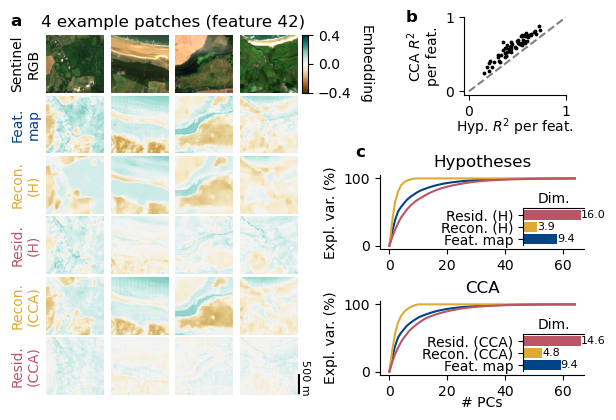

In [28]:
save_fig = True

full_length_fig = False

fig = plt.figure(figsize=(9 if full_length_fig else 6, 4))
n_rows_top, n_cols_top = 6, 8 if full_length_fig else 4
gs_top = fig.add_gridspec(n_rows_top, n_cols_top + 1, width_ratios=[1] * n_cols_top + [0.1], bottom=0.05, top=0.95, left=0.05, 
                          right=0.65 if full_length_fig else 0.49,
                         wspace=0.05, hspace=0.05)
# n_cols_bottom = 7
# gs_bottom = fig.add_gridspec(1, n_cols_bottom, width_ratios=[0.3, 1, 0.5, 0.3, 0.3, 1, 0.5],
#                               bottom=0.05, top=0.25, left=0.05, right=0.95,
#                             wspace=0.15, hspace=0.15)
ax_top = np.array([[fig.add_subplot(gs_top[ii, jj]) for jj in range(n_cols_top)] for ii in range(n_rows_top)])
ax_cbar = fig.add_subplot(gs_top[0, -1])
# ax_bottom = [fig.add_subplot(gs_bottom[0, jj]) for jj in range(n_cols_bottom)]
gs_right = fig.add_gridspec(2, 1, left=0.73 if full_length_fig else 0.61, 
                            # right=0.95, bottom=0.4, top=0.95, hspace=0.7)
                            right=0.95, bottom=0.1, top=0.6, hspace=0.7)
ax_right = [fig.add_subplot(gs_right[ii, 0]) for ii in range(2)]
gs_bottomright = fig.add_gridspec(1, 1, left=0.8 if full_length_fig else 0.75, 
                                #   right=0.92, bottom=0.07, top=0.25)
                                 right=0.92, bottom=0.8, top=0.995)
ax_bottomright = fig.add_subplot(gs_bottomright[0, 0])

patch_feat_combis = [(4, 42), (15, 42), (16, 42), (96, 42), (40, 60), (80, 30), (96, 50),
                     (33, 15), (55, 35), (77, 45), (88, 20), (99, 55), (12, 70), (25, 80)]
patch_feat_combis = patch_feat_combis[:n_cols_top]
dict_plot_feat_data = {
    'original': np.stack(features),
    'fit_ols_h': feat_hat_ols_h_img,
    'res_ols_h': feat_res_ols_h_img,
    'fit_ols_cc': feat_hat_ols_cc_img,
    'res_ols_cc': feat_res_ols_cc_img
}
name_dict = {'original': 'Feat.\nmap', 'fit_ols_cc': 'Recon.\n(CCA)', 'res_ols_cc': 'Resid.\n(CCA)',
              'fit_ols_h': 'Recon.\n(H)', 'res_ols_h': 'Resid.\n(H)'}
colour_ols_fit = "#ddaa33"
colour_ols_res = "#bb5566"
colour_original = '#004488'
color_dict = {'original': colour_original, 'fit_ols_cc': colour_ols_fit, 'res_ols_cc': colour_ols_res,
              'fit_ols_h': colour_ols_fit, 'res_ols_h': colour_ols_res}

for i_col, (i_patch, i_f) in enumerate(patch_feat_combis):
    ax_col = ax_top[:, i_col]

    ax_col[0].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[i_patch][:3], 0, 2), 0, 1), 0, 3000) / 2000)
    # vu.plot_sentinel(ax=ax_col[0], img=sentinel_eq[i_patch])
    # ax_col[0].set_title(f'F{i_f}, P{i_patch}', fontsize=10)

    for ii, (name, im_plot) in enumerate(dict_plot_feat_data.items()):
        vu.plot_feature(im_plot[i_patch][i_f], ax=ax_col[ii + 1], plot_cbar=False, lim_zscore=False)        
        corr_with_orig_feat = np.corrcoef(im_plot[i_patch][i_f].flatten(), features[i_patch][i_f].flatten())[0, 1]
        ax_col[ii + 1].set_xlabel(f'corr: {corr_with_orig_feat:.3f}', fontsize=8)
    for ax_ in ax_col:
        vu.naked(ax_)

    if i_col == 0:
        ax_col[0].set_ylabel('Sentinel\nRGB', fontsize=10)
        for ii, (name, _) in enumerate(dict_plot_feat_data.items()):
            ax_col[ii + 1].set_ylabel(name_dict[name], fontsize=10, color=color_dict[name])
    
    if i_col == n_cols_top - 1:
        cbar = plt.colorbar(mappable=ax_col[1].images[0], ax=ax_col[1], #fraction=0.046, pad=0.04,
                            cax=ax_cbar, ticks=[-0.4, 0, 0.4])
        ax_cbar.set_ylabel('Embedding', rotation=270, labelpad=15)

ax_top[0, 0].set_title('4 example patches (feature 42)', fontsize=12, ha='left', x=-0.1)
vu.add_scalebar(ax_top[-1, -1], location='bottom right vertical', fraction=0.5 / 1.28, label='500 m', fontsize=8)

## Bottom plots: 
## PCA explained variance plot H
## H OLS weight mat 
## PCA explained variance plot CC
## CC CCA + OLS weight mats 
## Dim bar plot

# ax_w_ols_h = ax_bottom[0]
ax_pca_h = ax_right[0]
ax_dim_h = ax_pca_h.inset_axes([0.7, 0.05, 0.3, 0.5])
# ax_w_cca = ax_bottom[3]
# ax_w_ols_cc = ax_bottom[4]
ax_pca_cca = ax_right[1]
ax_dim_cca = ax_pca_cca.inset_axes([0.7, 0.05, 0.3, 0.5])
ax_corr_recon = ax_bottomright


# ## Weight mat plots:
# for ax_, weight_mat_ in zip([ax_w_ols_h, ax_w_cca, ax_w_ols_cc],
#                             [weight_mat_ols_h, weight_mat_cc, weight_mat_ols_cc]):
#     ax_.imshow(weight_mat_ols_h[:, sorted_feature_inds].T, aspect='auto', cmap='bwr', interpolation='none',
#                   vmin=-np.max(np.abs(weight_mat_ols_h)), vmax=np.max(np.abs(weight_mat_ols_h)))



## Expl var plots:
# plot_pca_dim(dict_dim=dict_dim_all['res_ols_h'], dict_expl_var=dict_expl_var_all['res_ols_h'], ax=ax_pca_h)
# plot_pca_dim(dict_dim=dict_dim_all['res_ols_cc'], dict_expl_var=dict_expl_var_all['res_ols_cc'], ax=ax_pca_cca)
n = 100

ax_pca_h.plot(np.concatenate([[0], dict_expl_var_all['original'][n].mean(0)]) * 100, '-', c=color_dict['original'])
ax_pca_h.plot(np.concatenate([[0], dict_expl_var_all['fit_ols_h'][n].mean(0)]) * 100, '-', c=color_dict['fit_ols_h'])
ax_pca_h.plot(np.concatenate([[0], dict_expl_var_all['res_ols_h'][n].mean(0)]) * 100, '-', c=color_dict['res_ols_h']);

ax_pca_cca.plot(np.concatenate([[0], dict_expl_var_all['original'][n].mean(0)]) * 100, '-', c=color_dict['original'], label='Original features')
ax_pca_cca.plot(np.concatenate([[0], dict_expl_var_all['fit_ols_cc'][n].mean(0)]) * 100, '-', c=color_dict['fit_ols_cc'], label='Reconstructed');
ax_pca_cca.plot(np.concatenate([[0], dict_expl_var_all['res_ols_cc'][n].mean(0)]) * 100, '-', c=color_dict['res_ols_cc'], label='Residual');

# ax_pca_cca.legend(frameon=False, loc='upper right', bbox_to_anchor=(1, -0.5))

ax_pca_h.set_title('Hypotheses')
ax_pca_cca.set_title('CCA')
ax_pca_cca.set_xlabel('# PCs', labelpad=-2)
for ax_ in [ax_pca_cca, ax_pca_h]:
    ax_.set_ylabel('Expl. var. (%)')
    vu.despine(ax_)

## Dim bar plot:
for ax_, names in zip([ax_dim_h, ax_dim_cca],
                          [['original', 'fit_ols_h', 'res_ols_h'],
                           ['original', 'fit_ols_cc', 'res_ols_cc']]):
    mean_dim_list = []
    name_list = []
    colour_list = []
    for name in names:
        mean_dim = np.mean(dict_dim_all[name][n])
        sem_dim = np.std(dict_dim_all[name][n]) / np.sqrt(len(dict_dim_all[name][n]))
        mean_dim_list.append(mean_dim)
        name_list.append(name_dict[name])
        colour_list.append(color_dict[name])
    
    bars = ax_.barh(y=np.arange(3), width=mean_dim_list, yerr=sem_dim, color=colour_list)
    for rect, w in zip(bars, mean_dim_list):
        y = rect.get_y() + rect.get_height() / 2
        ax_.text(w, y, f'{w:.1f}', ha='left', va='center', fontsize=8)

    ax_.set_yticks(np.arange(3))
    ax_.set_yticklabels([n.replace('\n', ' ') for n in name_list])
    ax_.set_xlabel('Dim.')
    # move x ticks, ticklabelse and xlabel to the top of the axis
    ax_.xaxis.set_label_position('top')
    ax_.xaxis.tick_top()
    ax_.xaxis.set_ticks_position('top')
    ax_.set_xticks([])
    for sp in ['bottom', 'right']:
        ax_.spines[sp].set_visible(False)
    # vu.despine(ax_)
    
    # bars = ax_.bar(x=np.arange(3), height=mean_dim_list, yerr=sem_dim, color=colour_list)
    # for rect, h in zip(bars, mean_dim_list):
    #     x = rect.get_x() + rect.get_width() / 2
    #     ax_.text(x, h, f'{h:.1f}', ha='center', va='bottom', fontsize=8)

    # ax_.set_xticks([])
    # ax_.set_ylabel('Dim.')
    # vu.despine(ax_)

plot_type = 'r2_scatter'
if plot_type == 'corr_hexbin':
    ax_corr_recon.plot([-1, 1], [-1, 1], 'k--')
    cmap_ols_fit = plt.cm.get_cmap('Oranges')
    ax_corr_recon.hexbin(x=dict_corr_with_orig['fit_ols_h'], y=dict_corr_with_orig['fit_ols_cc'],
                        gridsize=30, cmap=cmap_ols_fit, mincnt=1)
    ax_corr_recon.set_xlabel(r"$\rho_H$", labelpad=-5)
    ax_corr_recon.set_ylabel(r"$\rho_{CC}$")
    ax_corr_recon.set_xlim([-0.2, 1])
    ax_corr_recon.set_ylim([-0.2, 1])
    vu.despine(ax_corr_recon)
    cbar = plt.colorbar(mappable=ax_corr_recon.collections[0], ax=ax_corr_recon)
    cbar.set_label('Counts', rotation=270, labelpad=15)
    cbar.set_ticks([0, 100, 200])
elif plot_type == 'r2_scatter':
    ax_corr_recon.plot([0, 1], [0, 1], '--', c='grey')
    ax_corr_recon.scatter(x=r2_per_feature_h, y=r2_per_feature_cc,  c='k', alpha=1, s=3)
    # ax_corr_recon.scatter(x=r2_per_feature_h.mean(), y=r2_per_feature_cc.mean(),  c='red', alpha=1, s=50, marker='x')
    ax_corr_recon.set_xlabel('Hyp. ' + r"$R^2$" + ' per feat.', labelpad=-2)
    ax_corr_recon.set_ylabel('CCA ' + r"$R^2$" + '\nper feat.')
    ax_corr_recon.set_xlim([-0.05, 1])
    ax_corr_recon.set_ylim([-0.05, 1])
    vu.despine(ax_corr_recon)

sys.path.append('/Users/tplas/repos/reproducible_figures/scripts')
import rep_fig_vis as rfv
rfv.add_panel_label(fig=fig, ax=ax_top[0][0], label_letter='a', x_offset=0.25 if full_length_fig else 0.05, y_offset=0.1, fontsize=12)
rfv.add_panel_label(fig=fig, ax=ax_right[0], label_letter='c', x_offset=3.07 if full_length_fig else 1.72, y_offset=0.2, fontsize=12)
# rfv.add_panel_label(fig=fig, ax=ax_right[1], label_letter='c', x_offset=3.07 if full_length_fig else 1.72, y_offset=0.1, fontsize=12)
rfv.add_panel_label(fig=fig, ax=ax_bottomright, label_letter='b', x_offset=8 if full_length_fig else 3.95, y_offset=-0.1, fontsize=12)

if save_fig:
    fig.savefig('../figs/fig3.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('../../ms_neureo/figs/fig3.pdf', bbox_inches='tight')